# Rice disease v.0.3

Huge Kaggle 12G dataset, 4 classes (3 disease + 1 healthy), Modern Architectures

https://www.kaggle.com/ellyanalinden/googlenet

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
from collections import Counter
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets,transforms, models
from torchvision.utils import make_grid

torch.autograd.set_detect_anomaly = True

import warnings
warnings.filterwarnings('ignore')

## Params

In [2]:
RANDOM_SEED = 9
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

TRAIN_SIZE = 0.9

In [3]:
avail = torch.cuda.is_available()
print(f'CUDA available: {avail}')
    
if avail:
    print(f'Device: {torch.cuda.get_device_name(torch.cuda.current_device())}')
    print(f'Memory allocated: {torch.cuda.memory_allocated()}')
    print(f'Memory cached:    {torch.cuda.memory_cached()}')
    

DEVICE = torch.device("cuda:0" if avail else "cpu")

CUDA available: True
Device: GeForce GTX 960
Memory allocated: 0
Memory cached:    0


## Utils

In [4]:
def count_parameters(model, verbose=True):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    if verbose:
        for item in params:
            print(f'{item:>8}')
    print(f'________\n{sum(params):>8}')

In [5]:
def show_images(loader, class_names, nrow=5, n_batches=1, figsize=(12,4)):
    # Grab the first batch of 10 images
    images = None
    labels = []
    
    for b, (img, lbl) in enumerate(loader): 
        if n_batches is not None and b >= n_batches:
            break
        
        images = img if images is None else torch.cat((images, img), dim=0)
        labels.extend(lbl.numpy())
        
    labels = np.array(labels).reshape(-1, nrow)
    
    # Print the labels
    print('Labels:\n', labels)
    print('\nClasses:', ' | '.join(np.array([class_names[i] for i in labels[0, :5]])), '...')

    im = make_grid(images, nrow=nrow)  # the default nrow is 8

    # Inverse normalize the images
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    im_inv = inv_normalize(im)

    # Print the images
    plt.figure(figsize=figsize)
    plt.imshow(np.transpose(im_inv.numpy(), (1, 2, 0)))

In [6]:
def plot_train_report(model, 
                      train_loader, valid_loader,
                      train_losses, valid_losses, train_corrects, valid_corrects, 
                      device):
    
    fig, ax = plt.subplots(1, 3, figsize=(17, 4))
    
    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    
    ax[0].plot(train_losses, label='training loss')
    ax[0].plot(valid_losses, label='validation loss')
    ax[0].set_title('Loss at the end of each epoch')
    ax[0].grid(True)
    ax[0].legend()

    ax[1].plot([100*t/train_len for t in train_corrects], label='training accuracy')
    ax[1].plot([100*t/valid_len for t in valid_corrects], label='validation accuracy')
    ax[1].set_title('Accuracy at the end of each epoch')
    ax[1].set_ylim((0, 100))
    ax[1].grid(True)
    ax[1].legend()
    
    evaluate_model(model, valid_loader, device, 'Validation', ax=ax[2])

In [7]:
def plot_confusion_matrix(y_true, y_pred, class_names, ax=None):
    ax = ax or plt.gca()
    
    cm = confusion_matrix(y_true, y_pred)
    df_cm = pd.DataFrame(cm, class_names, class_names)
    sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn', ax=ax)
    ax.set_xlabel("prediction")
    ax.set_ylabel("label (ground truth)")

In [8]:
def evaluate_model(model, data_loader, device, mark, ax=None):
    model.eval()
    with torch.no_grad():
        y_evals = []
        y_valids = []

        for X_valid, y_valid in data_loader:
            y_eval = model(X_valid.to(device)).cpu()
            y_evals += list(torch.argmax(y_eval, axis=1).numpy())
            y_valids += list(y_valid.numpy())

    plot_confusion_matrix(y_valids, y_evals, data_loader.dataset.classes, ax=ax)

    print(f'{mark} accuracy:', round((np.array(y_valids) == np.array(y_evals)).sum()*100/len(y_evals), 2), '%')

In [9]:
def save_progress(epoch, model, optimizer, 
                  train_losses, valid_losses, train_corrects, valid_corrects, 
                  prefix, folder):
    state = {
        'epoch': epoch, 
        'model_state': model.state_dict(), 
        'optimizer_state': optimizer.state_dict(), 
        'train_losses': train_losses, 
        'valid_losses': valid_losses, 
        'train_corrects': train_corrects, 
        'valid_corrects': valid_corrects
    }
    
    torch.save(state, f'{folder}/train_{prefix}.pt')

In [10]:
def restore_progress(model, optimizer,
                     train_losses, valid_losses, train_corrects, valid_corrects,
                     prefix, folder):
    state = torch.load(f'{folder}/train_{prefix}.pt')
    
    model.load_state_dict(state['model_state'])
    optimizer.load_state_dict(state['optimizer_state'])
    
    train_losses.extend(model['train_losses'])
    valid_losses.extend(model['valid_losses'])
    train_corrects.extend(model['train_corrects'])
    valid_corrects.extend(model['valid_corrects'])
    
    return state['epoch']

## Data

In [11]:
img_transforms = {
    'train': transforms.Compose([transforms.RandomRotation(30),
                                 transforms.RandomResizedCrop(224),
                                 transforms.RandomHorizontalFlip(),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])]),
    'valid': transforms.Compose([transforms.Resize(224),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize([0.485, 0.456, 0.406], 
                                                      [0.229, 0.224, 0.225])])
}

In [12]:
data_folder = 'data/kaggle12Gb/LabelledRice/Labelled'

In [13]:
all_data = datasets.ImageFolder(data_folder)
img_counts = Counter([img[1] for img in all_data.imgs])
cls_counts = {k:img_counts[i] for k,i in all_data.class_to_idx.items()}

In [14]:
print(all_data.class_to_idx)
print(cls_counts)
print('Total: ', len(all_data))

print('\nInitial stratification:')
print({cls : f'{round(100*cnt/len(all_data), 2)}%' for cls,cnt in cls_counts.items()})

{'BrownSpot': 0, 'Healthy': 1, 'Hispa': 2, 'LeafBlast': 3}
{'BrownSpot': 523, 'Healthy': 1488, 'Hispa': 565, 'LeafBlast': 779}
Total:  3355

Initial stratification:
{'BrownSpot': '15.59%', 'Healthy': '44.35%', 'Hispa': '16.84%', 'LeafBlast': '23.22%'}


In [15]:
all_cls = np.array([img[1] for img in all_data.imgs])
idx_to_class = np.array([[i, img] for i, img in enumerate(all_cls)])
np.random.shuffle(idx_to_class)

In [16]:
train_idx = []
valid_idx = []

class_idx = list(all_data.class_to_idx.values())
for i in class_idx:
    class_items = idx_to_class[idx_to_class[:, 1] == i][:, 0]
    train_len = int(len(class_items)*TRAIN_SIZE)
    
    train_idx += list(class_items[:train_len])
    valid_idx += list(class_items[train_len:])

assert set(train_idx) | set(valid_idx) == set(range(len(all_data)))

In [17]:
# ensure stratification
print('Initial stratification:')
print({cls : f'{round(100*cnt/len(all_cls), 2)}%' for (cls, cnt) in Counter(all_cls).items()})

print('\nTrain stratification:')
train_cls = all_cls[train_idx]
print({cls : f'{round(100*cnt/len(train_cls), 2)}%' for (cls, cnt) in Counter(train_cls).items()})

print('\nValidation stratification:')
valid_cls = all_cls[valid_idx]
print({cls : f'{round(100*cnt/len(valid_cls), 2)}%' for (cls, cnt) in Counter(valid_cls).items()})

Initial stratification:
{0: '15.59%', 1: '44.35%', 2: '16.84%', 3: '23.22%'}

Train stratification:
{0: '15.57%', 1: '44.37%', 2: '16.83%', 3: '23.23%'}

Validation stratification:
{0: '15.73%', 1: '44.21%', 2: '16.91%', 3: '23.15%'}


In [18]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [19]:
train_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['train']), 
                          batch_size=10, 
                          sampler=train_sampler,
                          pin_memory=False,
                          num_workers=4)
valid_loader = DataLoader(datasets.ImageFolder(data_folder, transform=img_transforms['valid']), 
                          batch_size=100, 
                          sampler=valid_sampler,
                          pin_memory=False,
                          num_workers=4)

In [20]:
# show_images(train_loader, all_data.classes, nrow=8, n_batches=1, figsize=(28, 7))

## Train

In [21]:
def train(model, criterion, optimizer, 
          train_loader, valid_loader, 
          n_epoch, device,
          out_train_losses,
          out_valid_losses,
          out_train_corrects,
          out_valid_corrects,
          prefix
         ):
    start_time = time.time()

    train_len = len(train_loader.sampler.indices)
    valid_len = len(valid_loader.sampler.indices)
    n_train_batches = int(train_len/train_loader.batch_size)
    n_valid_batches = int(valid_len/valid_loader.batch_size)
    best_valid_accuracy = 0
    
    print('Begin...')
    
    for i in range(n_epoch):
        
        # train
        
        model.train()
        
        train_correct = 0
        
        for b, (X_train, y_train) in enumerate(train_loader):
            X_train = X_train.to(device)
            y_train = y_train.to(device)
            optimizer.zero_grad()
            
            y_pred = model(X_train)
            loss = criterion(y_pred, y_train)
            loss.backward()
            optimizer.step()

            y_pred = torch.max(y_pred, dim=1)[1]
            train_correct += (y_pred == y_train).sum()
            
            if b%100 == 0:
                print(f'---- batch: {b}({n_train_batches})')
            
        loss_val = round(float(loss), 2)
        correct_pct = round(train_correct.item()*100/train_len, 2)
        print(f'Epoch: {i+1}\tTRAIN\tLoss: {loss_val}\tCorrect: {train_correct}/{train_len}({correct_pct}%)')
    
        out_train_losses.append(loss_val)
        out_train_corrects.append(train_correct)
        
        # validation
        
        model.eval()
        
        valid_correct = 0
        y_evals = []
        y_valids = []
        
        with torch.no_grad():
            for b, (X_valid, y_valid) in enumerate(valid_loader):
                X_valid = X_valid.to(device)
                y_valid = y_valid.to(device)
                y_eval = model(X_valid)
                loss = criterion(y_eval, y_valid)
                
                y_eval = torch.max(y_eval, dim=1)[1]
                valid_correct += (y_eval == y_valid).sum()
                y_evals += list(y_eval.cpu().view(-1))
                y_valids += list(y_valid.cpu().view(-1))
            
        loss_val = round(float(loss), 2)
        correct_pct = round(valid_correct.item()*100/valid_len, 2)
        print(f'\t\tVALID.:\tLoss: {loss_val}\tCorrect: {valid_correct}/{valid_len}({correct_pct}%)')
        print('----------------------------------------')
    
        out_valid_losses.append(loss_val)
        out_valid_corrects.append(valid_correct)
        
        # plot results
        plot_confusion_matrix(y_valids, y_evals, train_loader.dataset.classes)
        plt.show()
        
        # save results
        if (i+1)%50==0:
            save_progress(i+1, 
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          f'{prefix}_e{i+1}', 'progress')

        # save the best
        if correct_pct > best_valid_accuracy:
            best_valid_accuracy = correct_pct
            save_progress(i+1,
                          model, optimizer, 
                          out_train_losses, out_valid_losses, out_train_corrects, out_valid_corrects, 
                          f'{prefix}_e{i+1}_best{correct_pct}', 'progress')
            
            print('\tBest validation accuracy:', best_valid_accuracy)

    end_time = time.time()
    print(f'End.\nDuration: {time.time() - start_time:.0f} seconds')

## GoogleNet

In [34]:
model_googlenet = models.googlenet(pretrained=True)

In [35]:
count_parameters(model_googlenet, verbose=False)

________
 6624904


In [36]:
next(model_googlenet.parameters()).is_cuda

False

In [37]:
for param in model_googlenet.parameters():
    param.requires_grad=True

In [38]:
n_inputs = model_googlenet.fc.in_features
model_googlenet.fc = nn.Linear(n_inputs, 4)
model_googlenet = model_googlenet.to(DEVICE)

count_parameters(model_googlenet, verbose=False)

________
 5602979


In [39]:
optimizer = torch.optim.Adam(model_googlenet.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

In [40]:
train_losses = []
valid_losses = []
train_corrects = []
valid_corrects = []

In [41]:
# restore_progress(model, optimizer,
#                  train_losses, valid_losses, train_corrects, valid_corrects,
#                  'googlenet_e240_best86.35','progress')

In [43]:
train(model_googlenet, criterion, optimizer,
      train_loader, valid_loader, 
      n_epoch=300, device=DEVICE,
      out_train_losses=train_losses,
      out_valid_losses=valid_losses,
      out_train_corrects=train_corrects,
      out_valid_corrects=valid_corrects,
      prefix='googlenet')

Begin...
torch.Size([10, 3])
tensor([-0.1763,  0.4334, -0.5921], device='cuda:0', grad_fn=<SelectBackward>)
torch.Size([10])
tensor(2, device='cuda:0')


Exception: @@@@@@@@@@@@@@@@@@@@@@

Validation accuracy: 91.79 %


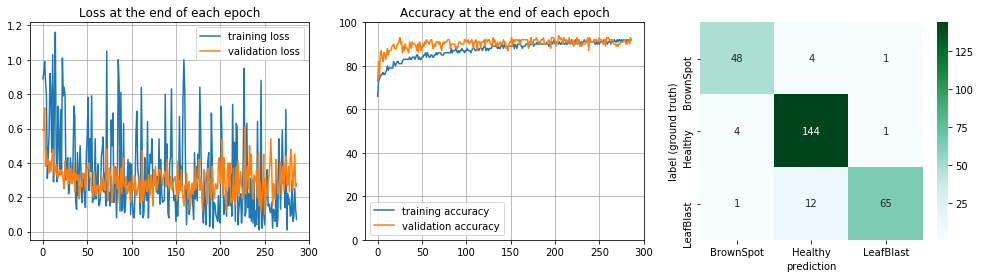

In [31]:
plot_train_report(model_googlenet, 
                  train_loader, valid_loader,
                  train_losses, valid_losses, train_corrects, valid_corrects, 
                  DEVICE)